In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

import logging

from registration_utilities import *

from collections import defaultdict

In [5]:
atlas_name = 'atlasV2'

In [6]:
train_sample_scheme = 1
global_transform_scheme = 1
local_transform_scheme = 2
trial_idx = 0

In [32]:
parameters_allLandmarks_allStacks = defaultdict(dict)
subject_centroid_allLandmarks_allStacks = defaultdict(dict)

for name_s in structures_sided:
    for stack in all_stacks:

        # Read local tx parameters
        local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
        DataManager.load_local_alignment_parameters(stack_moving=atlas_name,
                                                    stack_fixed=stack,
                                                    train_sample_scheme=train_sample_scheme,
                                                    global_transform_scheme=global_transform_scheme,
                                                     local_transform_scheme=local_transform_scheme,
                                                    trial_idx=trial_idx,
                                                   label=name_s)

        parameters_allLandmarks_allStacks[name_s][stack] = local_params
        subject_centroid_allLandmarks_allStacks[name_s][stack] = centroid_f
        
parameters_allLandmarks_allStacks.default_factory = None
subject_centroid_allLandmarks_allStacks.default_factory = None

In [22]:
# sort structures by rostral-caudal position

structures_sided_sorted_by_x = [name for c, name in \
 sorted([(np.mean(cs.values(), axis=0)[0], n) for n, cs in subject_centroid_allLandmarks_allStacks.iteritems()])]

print structures_sided_sorted_by_x

In [184]:
# small adjustment
# structures_sided_sorted_by_x = ['SNC_R', 'SNC_L', 'SNR_R', 'SNR_L', 'RMC_R', 'RMC_L', 'SC', '3N_R', '3N_L', 'Pn_R', 'Pn_L', 'PBG_R', 'PBG_L', 'VLL_R', 'VLL_L', '4N_R', '4N_L', 'RtTg', 'IC', 'Tz_R', 'Tz_L', '5N_R', '5N_L', 'LC_R', 'LC_L', 'VCA_R', 'VCA_L', '7n_R', '7n_L', '6N_R', '6N_L', '7N_R', '7N_L', 'VCP_R', 'VCP_L', 'DC_R', 'DC_L', 'Sp5O_R', 'Sp5O_L', 'Amb_R', 'Amb_L', 'Sp5I_R', 'Sp5I_L', 'AP', '12N', '10N_R', '10N_L', 'LRt_R', 'LRt_L', 'Sp5C_R', 'Sp5C_L']
structures_sided_sorted_by_x = ['SNC_R', 'SNC_L', 'SNR_R', 'SNR_L', 'RMC_R', 'RMC_L', 'SC', '3N_R', '3N_L', 'Pn_R', 'Pn_L', 'PBG_R', 'PBG_L', 'VLL_R', 'VLL_L', '4N_R', '4N_L', 'RtTg', 'IC', 'Tz_R', 'Tz_L', '5N_R', '5N_L', 'LC_R', 'LC_L', 'VCA_R', 'VCA_L', '7n_R', '7n_L', '6N_R', '6N_L', '7N_R', '7N_L', 'VCP_R', 'VCP_L', 'DC_R', 'Sp5O_L', 'Amb_R', 'Amb_L', 'Sp5I_R', 'Sp5I_L', '12N', '10N_R', '10N_L', 'LRt_R', 'LRt_L', 'Sp5C_R', 'Sp5C_L']
print structures_sided_sorted_by_x

No vtk


['SNC_R', 'SNC_L', 'SNR_R', 'SNR_L', 'RMC_R', 'RMC_L', 'SC', '3N_R', '3N_L', 'Pn_R', 'Pn_L', 'PBG_R', 'PBG_L', 'VLL_R', 'VLL_L', '4N_R', '4N_L', 'RtTg', 'IC', 'Tz_R', 'Tz_L', '5N_R', '5N_L', 'LC_R', 'LC_L', 'VCA_R', 'VCA_L', '7n_R', '7n_L', '6N_R', '6N_L', '7N_R', '7N_L', 'VCP_R', 'VCP_L', 'DC_R', 'Sp5O_L', 'Amb_R', 'Amb_L', 'Sp5I_R', 'Sp5I_L', '12N', '10N_R', '10N_L', 'LRt_R', 'LRt_L', 'Sp5C_R', 'Sp5C_L']


In [185]:
downsample_factor = 32
xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor

In [186]:
txs_allLandmarks = defaultdict(list)
tys_allLandmarks = defaultdict(list)
tzs_allLandmarks = defaultdict(list)
txyzs_allLandmarks = defaultdict(list)

for name, lm_tforms in parameters_allLandmarks_allStacks.iteritems():
    for stack, T in lm_tforms.iteritems():
        Tm = np.reshape(T, (3,4))
        t = Tm[:, 3]
#         R = Tm[:, :3]
        
        txs_allLandmarks[name].append(t[0] * xy_pixel_distance_downsampled)
        tys_allLandmarks[name].append(t[1] * xy_pixel_distance_downsampled)
        tzs_allLandmarks[name].append(t[2] * xy_pixel_distance_downsampled)
        txyzs_allLandmarks[name].append(np.sqrt(t[0]**2+t[1]**2+t[2]**2) * xy_pixel_distance_downsampled)

In [187]:
names2_sorted_by_x = []
for name in structures_sided_sorted_by_x:
    if '_' in name:
        name_u, suffix = name.split('_')
        names2_sorted_by_x.append(name_u + '(' + suffix + ')')
    else:
        names2_sorted_by_x.append(name)

In [188]:
outliers = {}

txyzs_allLandmarks_outlierRemoved = {}
for n, ps in txyzs_allLandmarks.iteritems():
    first_quartile = np.percentile(ps, 25)
    third_quartile = np.percentile(ps, 75)
    IQR = third_quartile - first_quartile
    ps = np.array(ps)
    is_outlier = (ps < first_quartile - 1. * IQR) | (ps > third_quartile + 1. * IQR)
    txyzs_allLandmarks_outlierRemoved[n] = ps[~is_outlier]
    
    if np.count_nonzero(is_outlier) > 0:
        outlier_indices = np.where(is_outlier)[0]
        outliers[n] = [parameters_allLandmarks_allStacks['6N_L'].keys()[i] for i in outlier_indices]
        print n, outliers[n]
    
#     mu = np.mean(ps)
#     std = np.std(ps)
#     txs_allLandmarks_outlierRemoved[n] = np.array(ps)[np.abs(ps - mu) < 2. * std]
    
write_dict_to_txt(outliers, '/home/yuncong/Brain/outliers.txt', fmt='%s')

Sp5C_L ['MD603']
Pn_L ['MD598']
7N_R ['MD593']
PBG_L ['MD591', 'MD598']
VLL_L ['MD598']
VLL_R ['MD598']
7N_L ['MD598']
PBG_R ['MD594']
RtTg ['MD603']
Sp5C_R ['MD590']
Pn_R ['MD603']
LRt_L ['MD598']
SNR_L ['MD603', 'MD598']
SNR_R ['MD603', 'MD585']
Sp5O_L ['MD603', 'MD585']
DC_R ['MD602', 'MD593', 'MD598']
VCA_L ['MD603', 'MD595']
3N_L ['MD603', 'MD591', 'MD595']
6N_R ['MD602', 'MD585', 'MD589', 'MD598']
5N_L ['MD603', 'MD598']
SNC_L ['MD603', 'MD598']
SNC_R ['MD585']
RMC_L ['MD603', 'MD594']
IC ['MD603', 'MD595']
VCA_R ['MD591']
VCP_R ['MD603', 'MD592']
LC_R ['MD595']
7n_R ['MD603', 'MD591']
4N_R ['MD585']
Tz_L ['MD603', 'MD598']
7n_L ['MD591']
4N_L ['MD603']
10N_L ['MD585']
VCP_L ['MD593', 'MD585']
Amb_L ['MD598']


In [189]:
txs_allLandmarks_averaged = {n: ps-np.mean(txs_allLandmarks[n]) for n, ps in txs_allLandmarks.iteritems()}
tys_allLandmarks_averaged = {n: ps-np.mean(tys_allLandmarks[n]) for n, ps in tys_allLandmarks.iteritems()}
tzs_allLandmarks_averaged = {n: ps-np.mean(tzs_allLandmarks[n]) for n, ps in tzs_allLandmarks.iteritems()}
txyzs_allLandmarks_averaged = {n: ps-np.mean(txyzs_allLandmarks_outlierRemoved[n]) for n, ps in txyzs_allLandmarks_outlierRemoved.iteritems()}

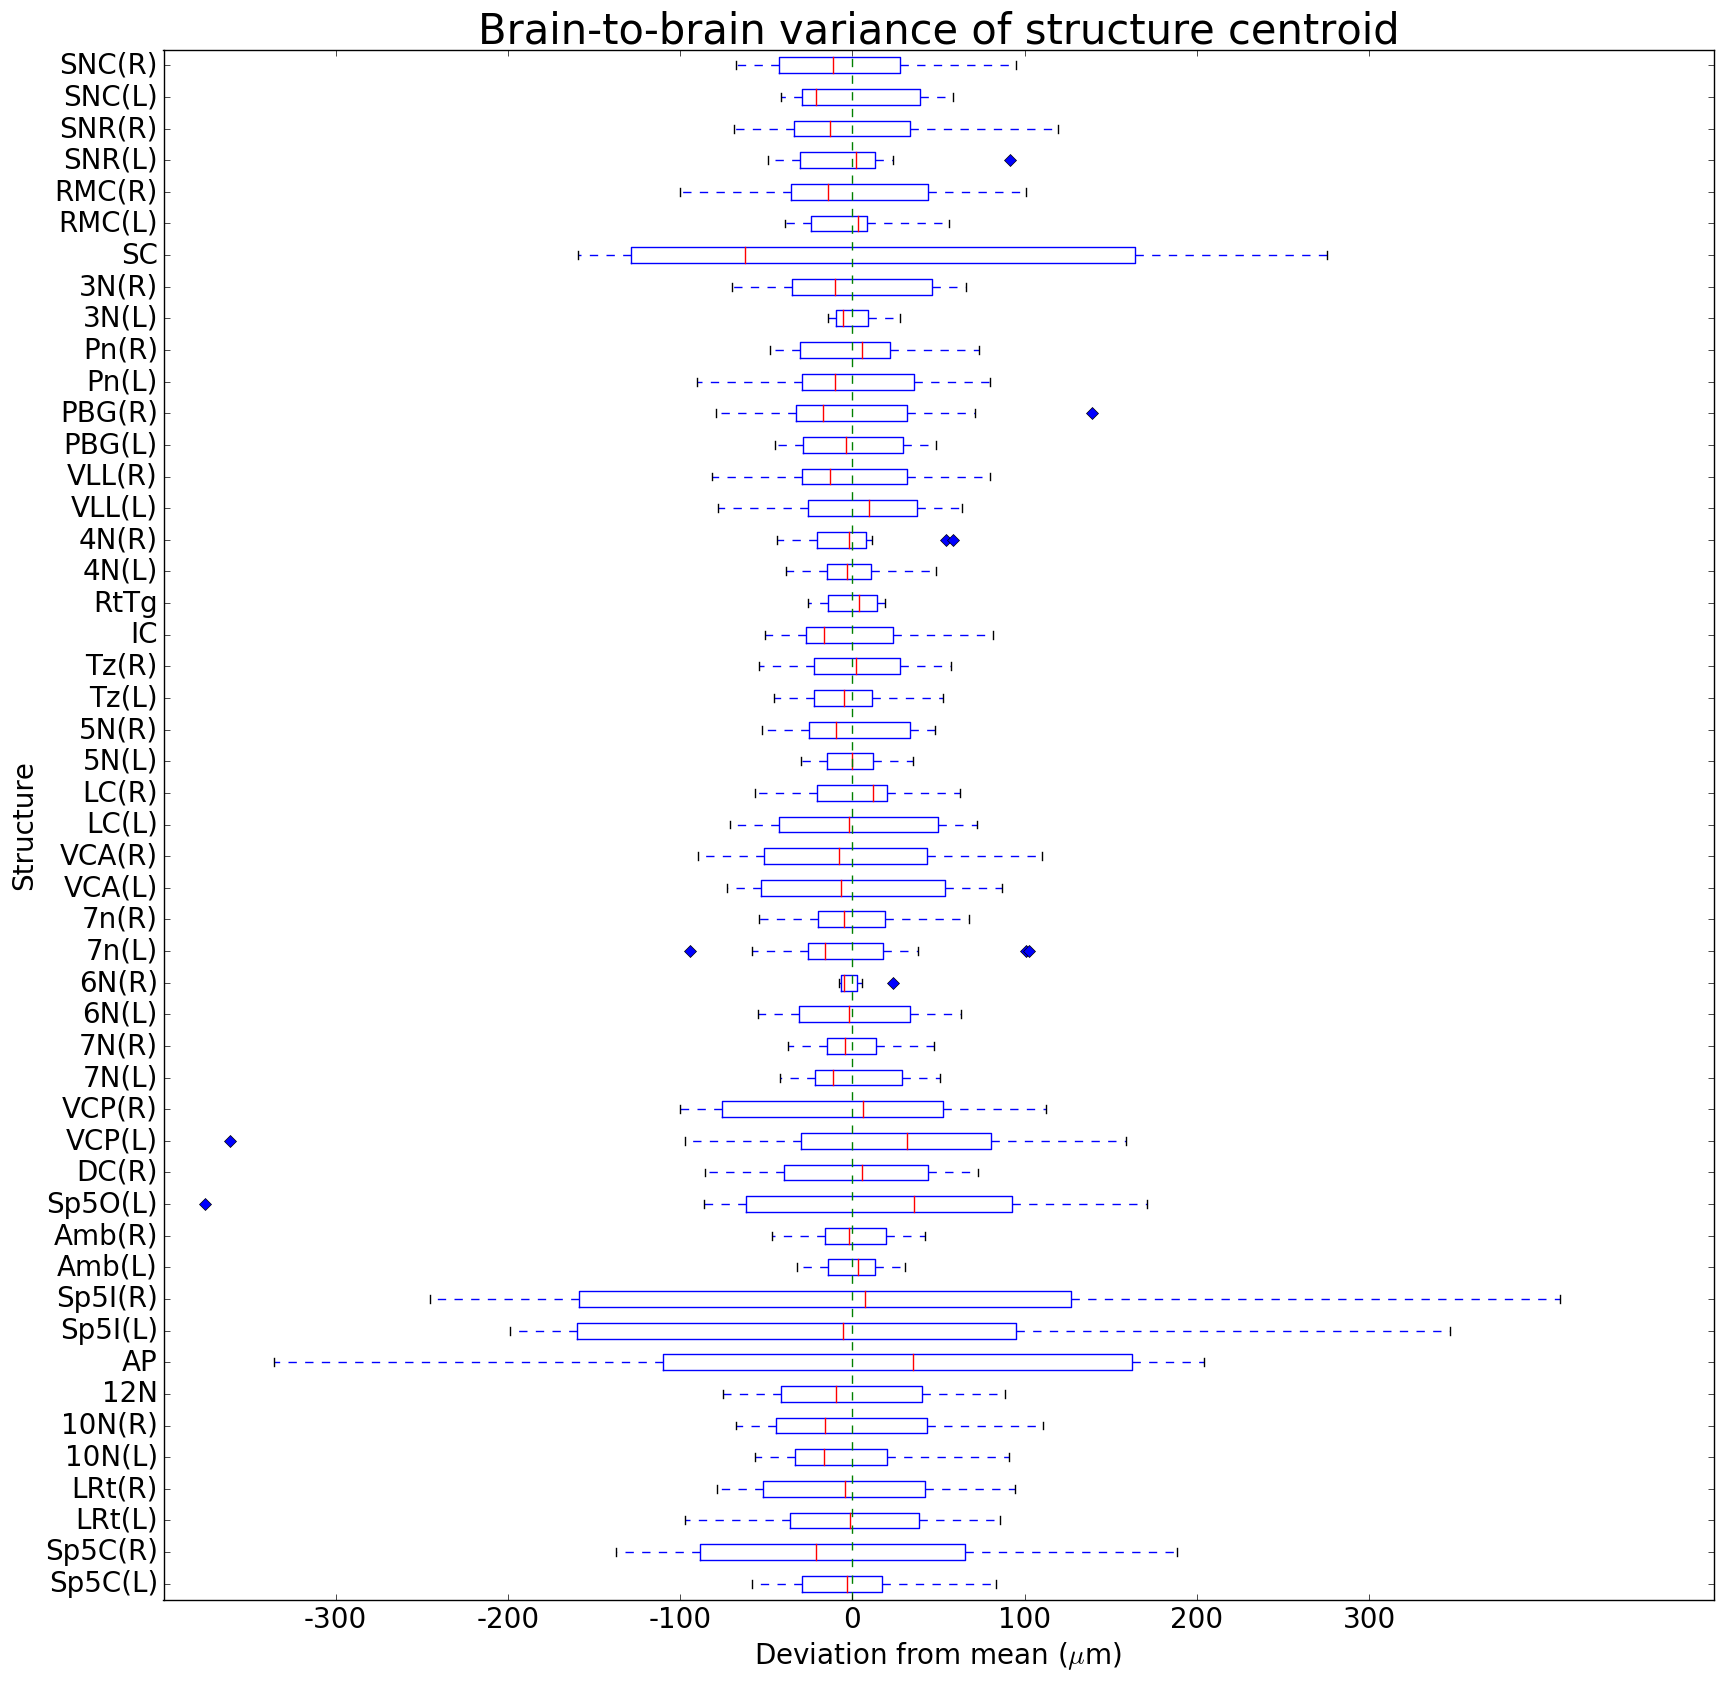

In [144]:
axes = [None for _ in range(1)]

for i, (d, v) in enumerate(zip([txyzs_allLandmarks_averaged], 
                               ['t'])):

#     names = sorted(d.keys())
    data = np.array([d[name] for name in structures_sided_sorted_by_x[::-1]]).T

    fig, axes[i] = plt.subplots(1,1,figsize=(20,20))
    
    axes[i].boxplot(data, 0, 'gD', 0);
#     axes[i].set_xlim([-300, 300])
    axes[i].set_xticks(np.arange(-300, 400, 100));
    axes[i].set_xticklabels(np.arange(-300, 400, 100), fontsize=20);
    axes[i].set_xlabel('Deviation from mean ($\mu$m)', fontsize=20);

    direction = ''
    axes[i].set_title('Brain-to-brain variance of structure centroid', fontsize=30)
    
    axes[i].set_ylabel('Structure', fontsize=20)
    axes[i].set_yticks(1 + np.arange(len(names2_sorted_by_x)))
    axes[i].set_yticklabels(names2_sorted_by_x[::-1], rotation='0', fontsize=20)
    axes[i].axvline(0, color='g', ls='dashed')
    plt.show();
    
    
# plt.setp(axes, xticks=range(1, 1+data.shape[1]), xticklabels=names)
# plt.tight_layout(h_pad=5.0);
# plt.show();

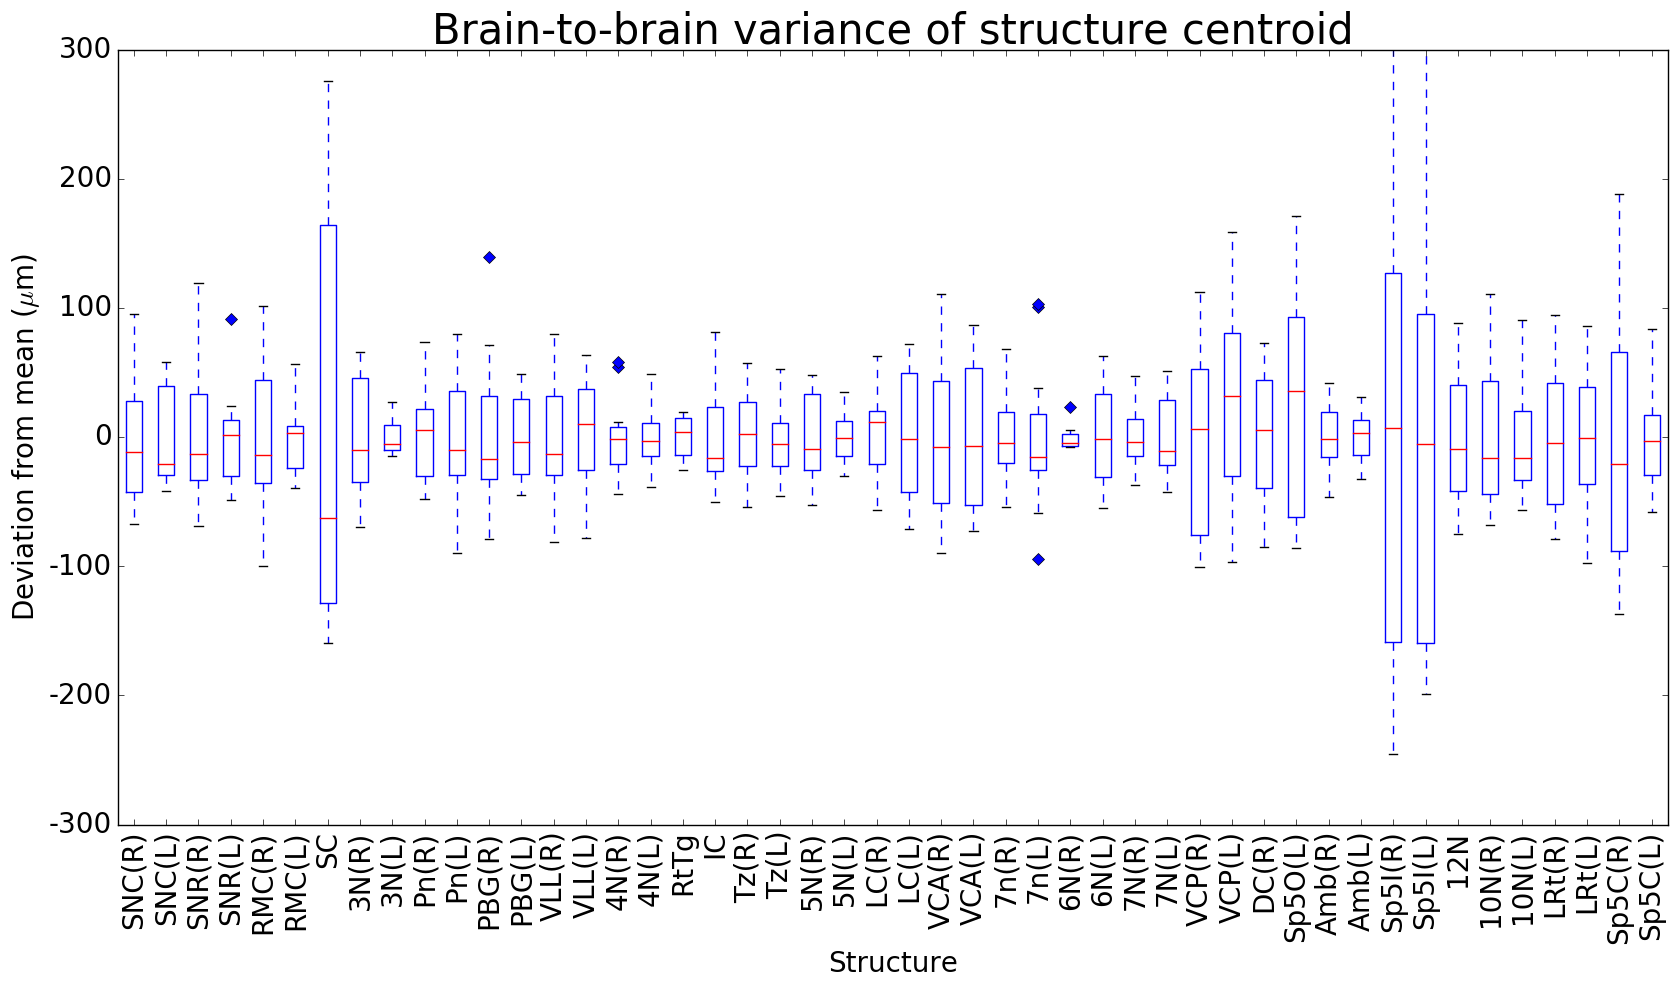

In [190]:
# fig, axes = plt.subplots(3, 1, figsize=(20,40), squeeze=True)

axes = [None for _ in range(4)]

# for i, (d, v) in enumerate(zip([txs_allLandmarks, tys_allLandmarks, tzs_allLandmarks], ['tx', 'ty', 'tz'])):
# for i, (d, v) in enumerate(zip([txs_allLandmarks_averaged, tys_allLandmarks_averaged, tzs_allLandmarks_averaged, txyzs_allLandmarks_averaged], 
#                                ['tx', 'ty', 'tz', 't'])):
for i, (d, v) in enumerate(zip([txyzs_allLandmarks_averaged], ['t'])):

#     names = sorted(d.keys())
    data = np.array([d[name] for name in structures_sided_sorted_by_x]).T

    fig, axes[i] = plt.subplots(1,1,figsize=(20,10))
    
    axes[i].boxplot(data, 0, 'gD');
    axes[i].set_ylim([-300, 300])
    axes[i].set_yticks(np.arange(-300, 400, 100));
    axes[i].set_yticklabels(np.arange(-300, 400, 100), fontsize=20);
    axes[i].set_ylabel('Deviation from mean ($\mu$m)', fontsize=20);
    direction = ''
    axes[i].set_title('Brain-to-brain variance of structure centroid', fontsize=30)
    
    axes[i].set_xlabel('Structure', fontsize=20)
    axes[i].set_xticks(1 + np.arange(len(names2_sorted_by_x)))
    axes[i].set_xticklabels(names2_sorted_by_x, rotation='90', fontsize=20)
#     axes[i].axvline(0, color='g', ls='dashed')
    plt.show();
    
# plt.setp(axes, xticks=range(1, 1+data.shape[1]), xticklabels=names)
# plt.tight_layout(h_pad=5.0);
# plt.show();

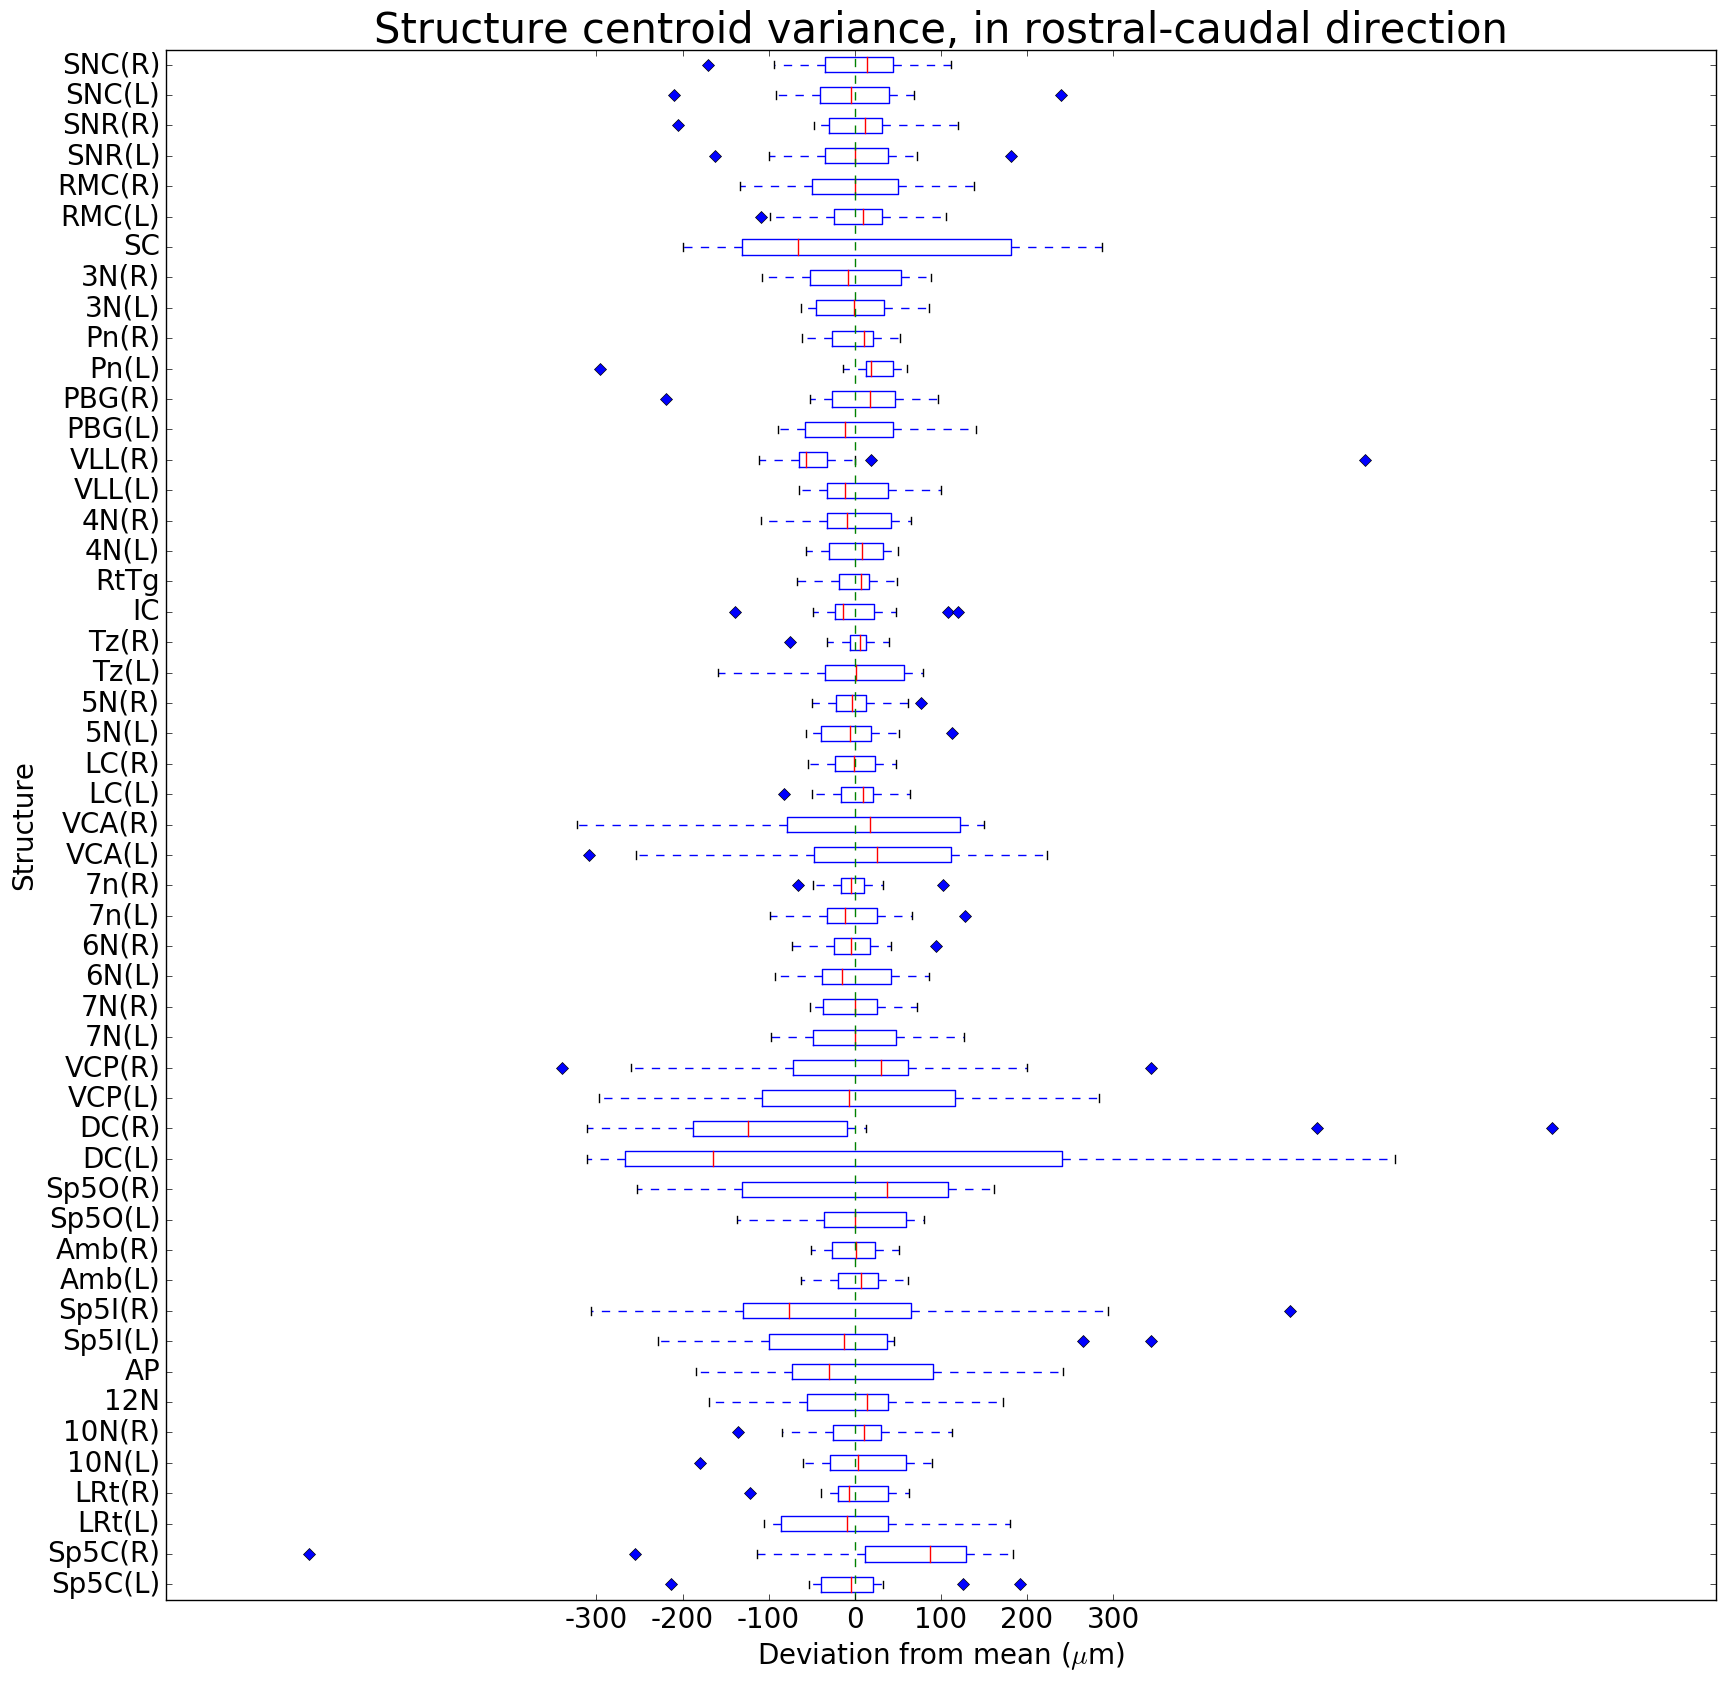

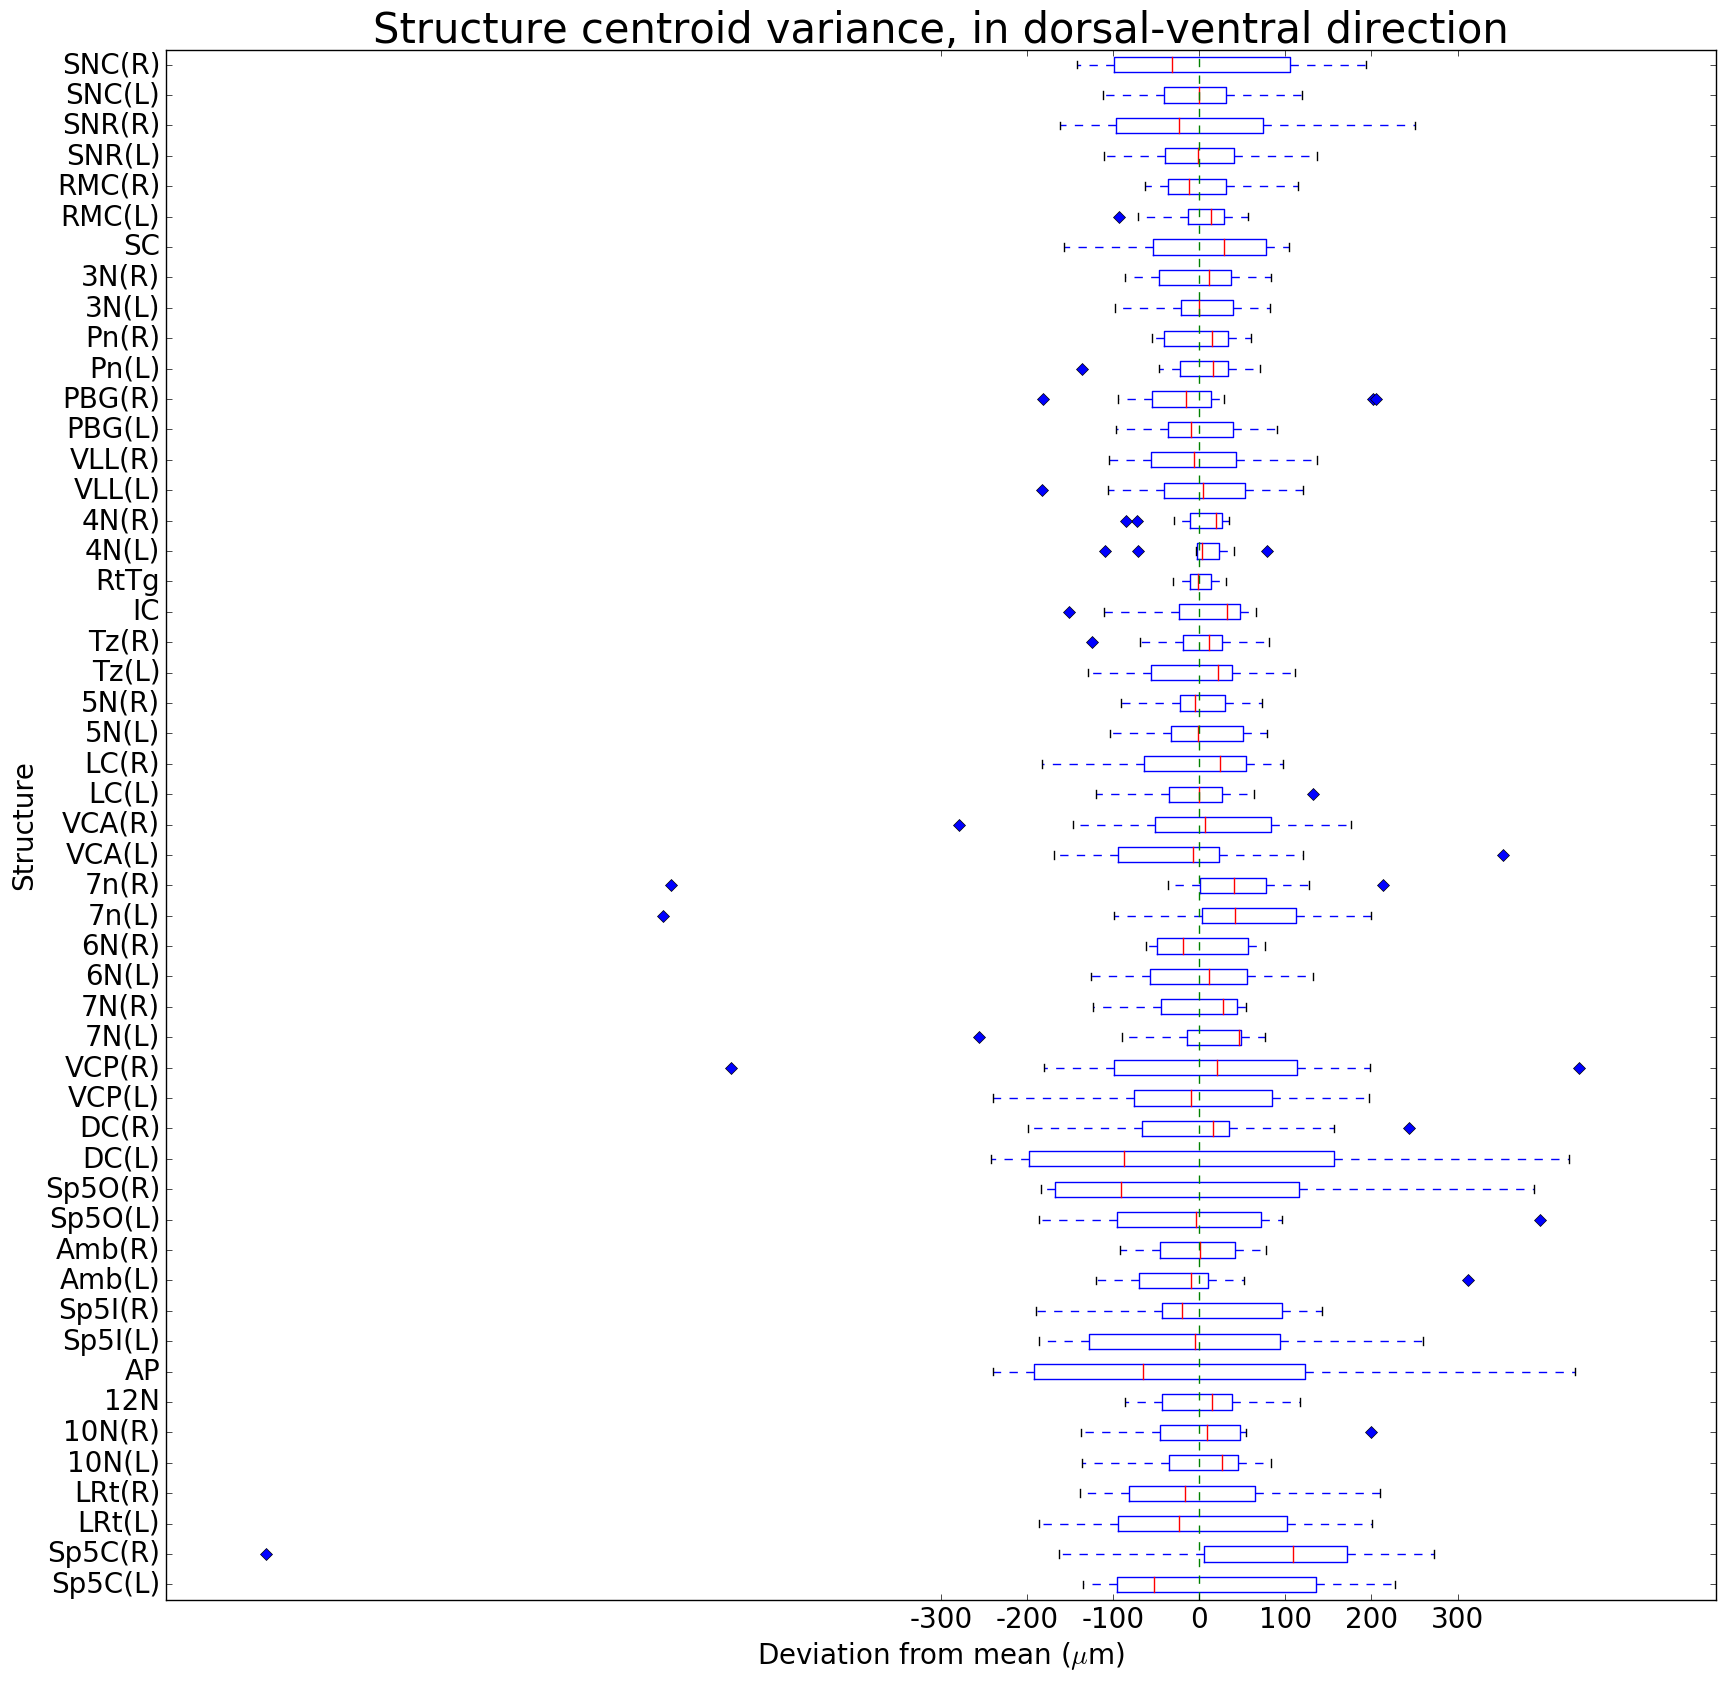

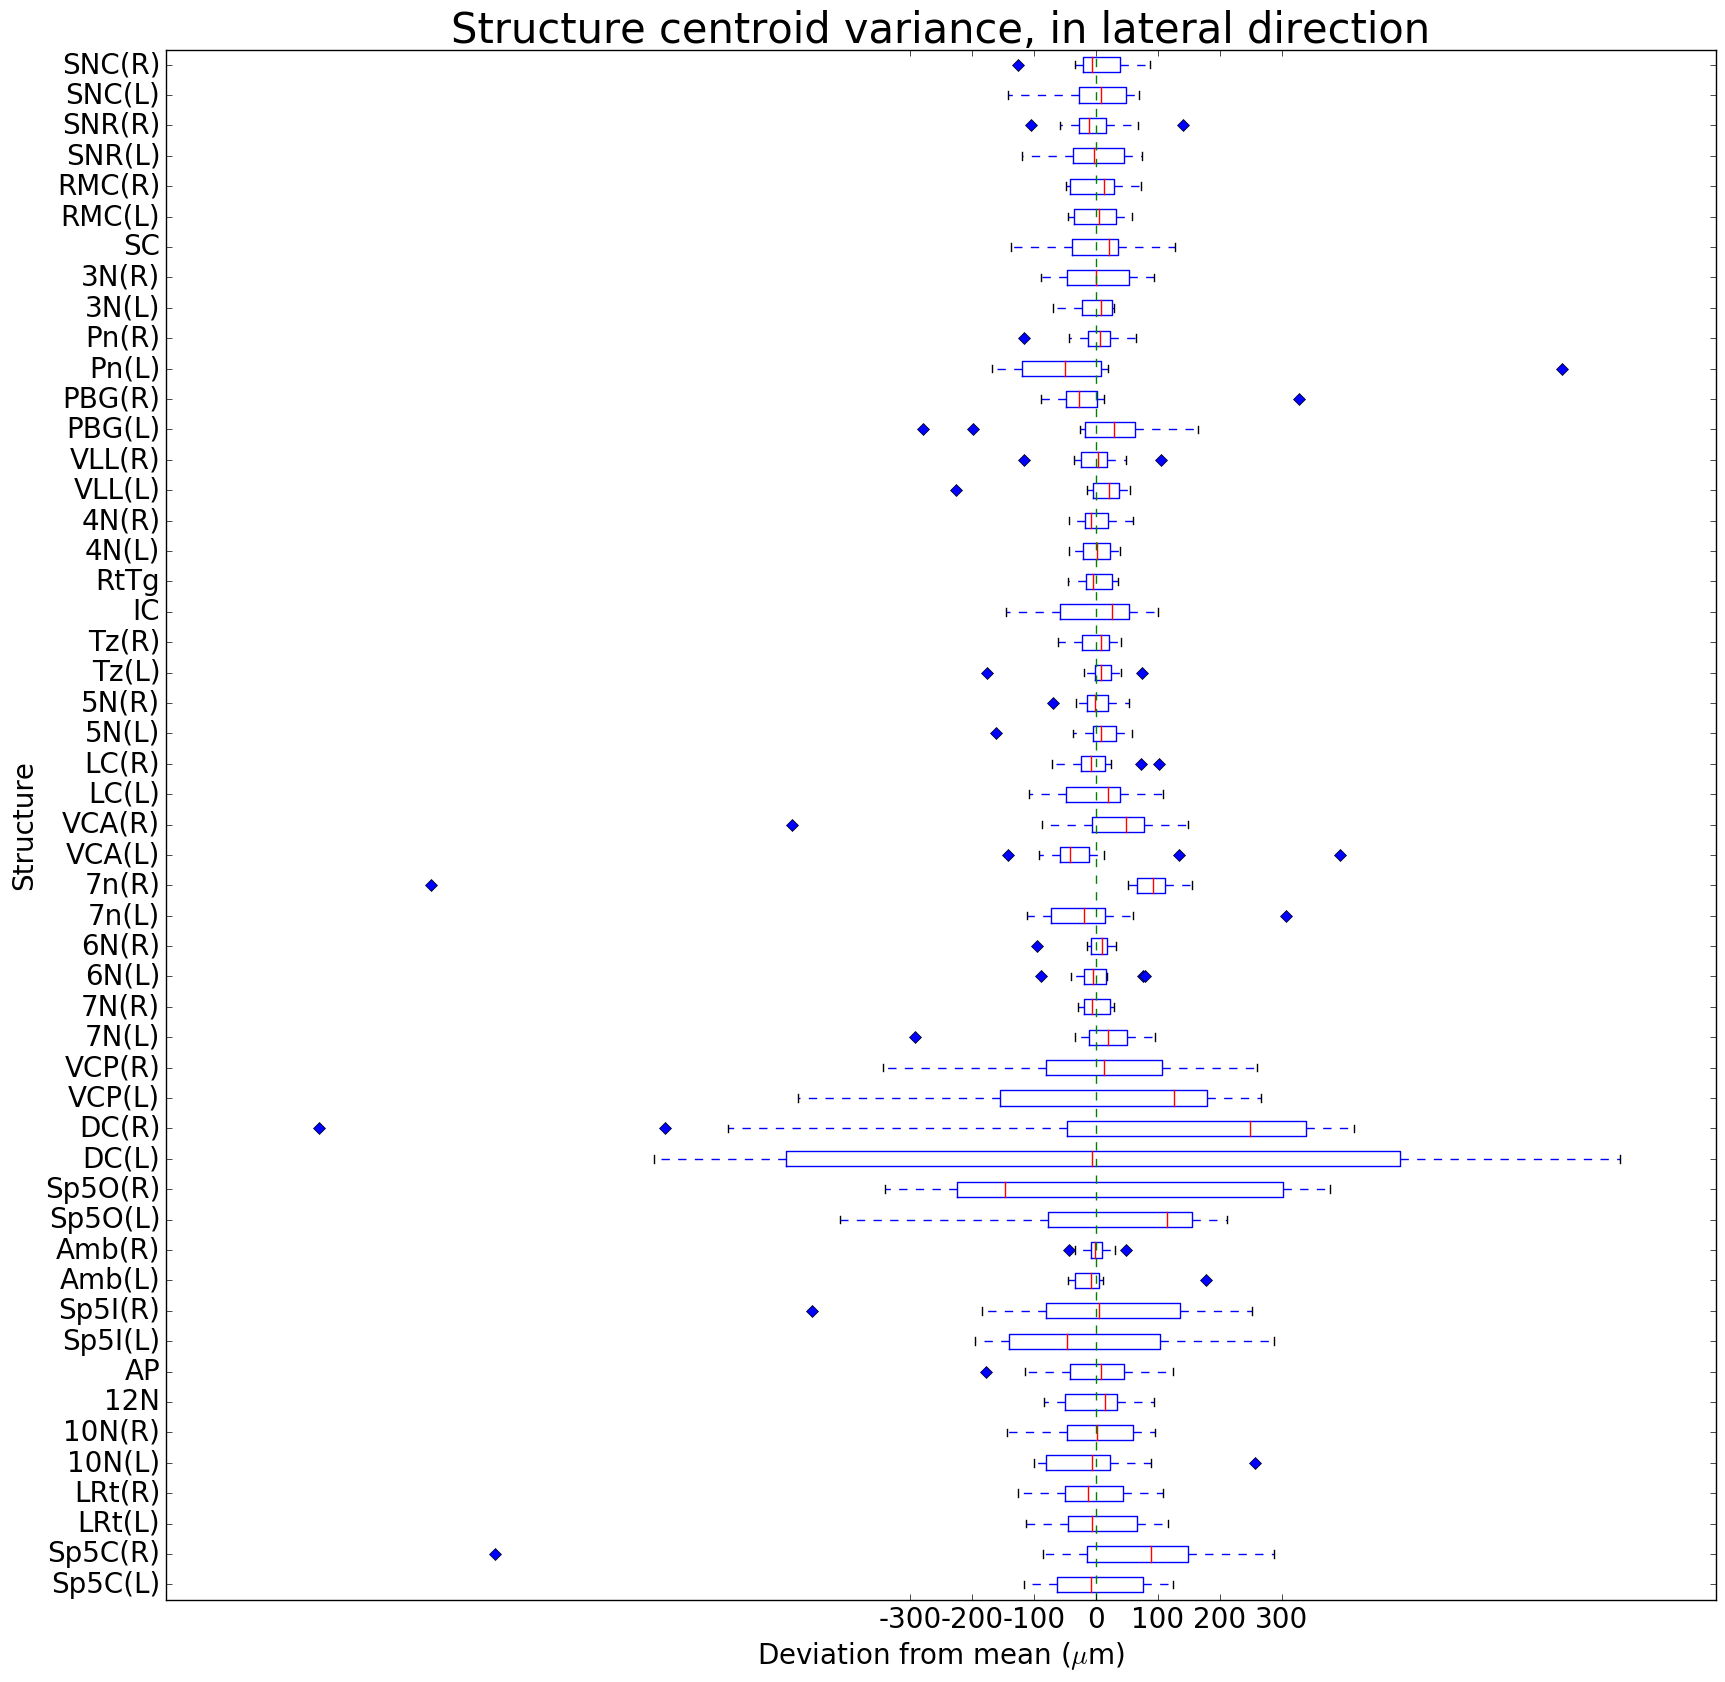

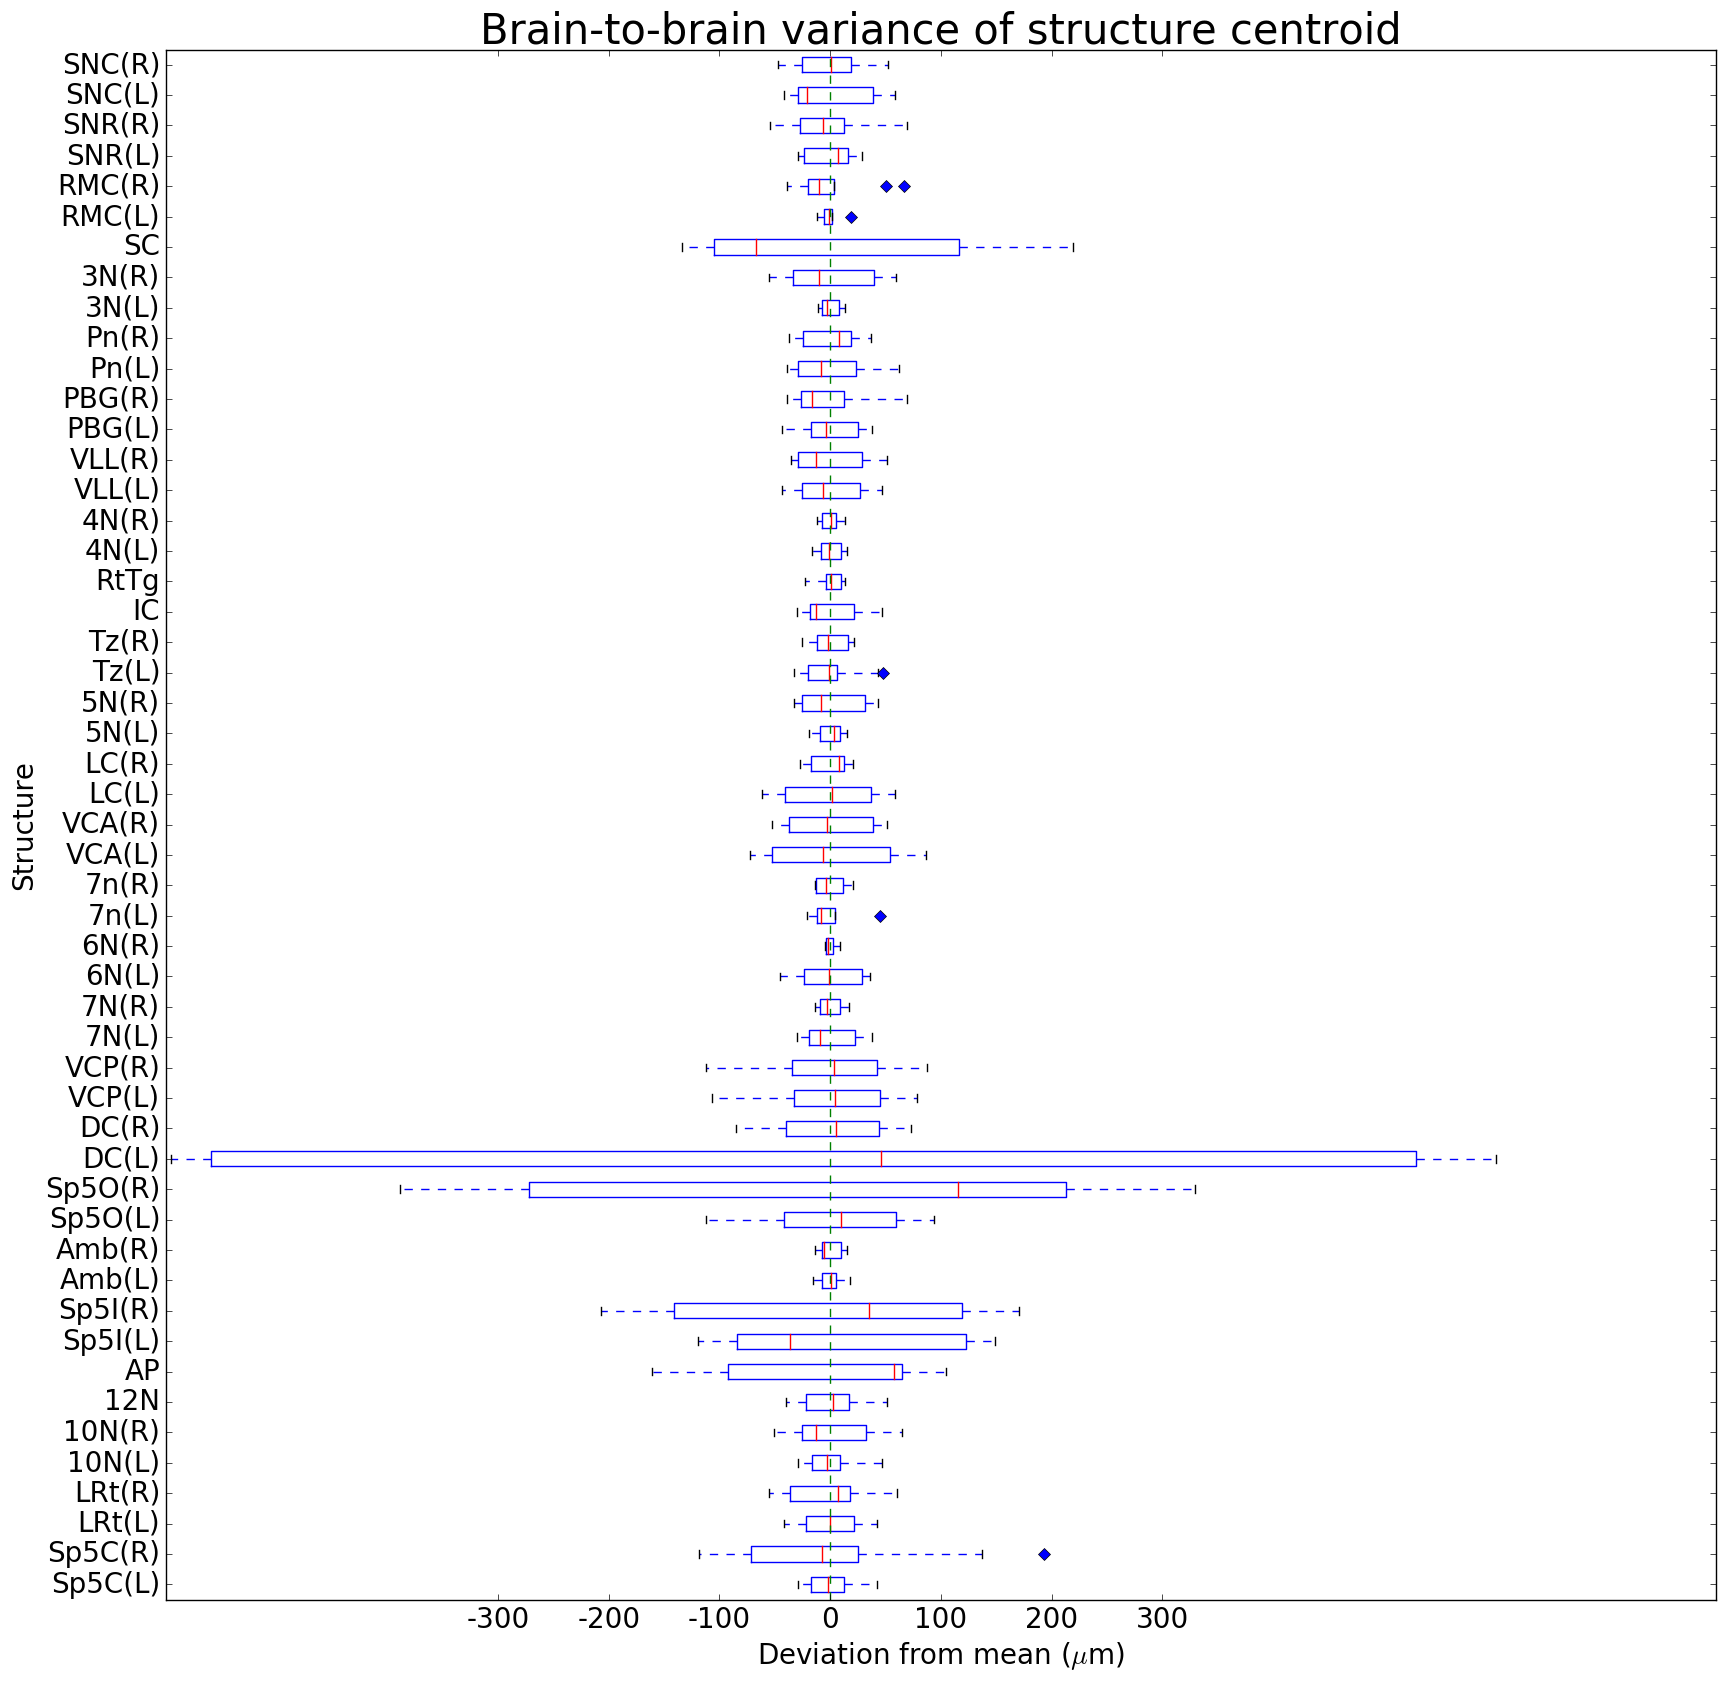

In [123]:
# fig, axes = plt.subplots(3, 1, figsize=(20,40), squeeze=True)

axes = [None for _ in range(4)]

# for i, (d, v) in enumerate(zip([txs_allLandmarks, tys_allLandmarks, tzs_allLandmarks], ['tx', 'ty', 'tz'])):
for i, (d, v) in enumerate(zip([txs_allLandmarks_averaged, tys_allLandmarks_averaged, tzs_allLandmarks_averaged, txyzs_allLandmarks_averaged], 
                               ['tx', 'ty', 'tz', 't'])):

#     names = sorted(d.keys())
    data = np.array([d[name] for name in structures_sided_sorted_by_x[::-1]]).T

    fig, axes[i] = plt.subplots(1,1,figsize=(20,20))
    
    axes[i].boxplot(data, 0, 'gD', 0);
#     axes[i].set_xlim([-300, 300])
    axes[i].set_xticks(np.arange(-300, 400, 100));
    axes[i].set_xticklabels(np.arange(-300, 400, 100), fontsize=20);
    axes[i].set_xlabel('Deviation from mean ($\mu$m)', fontsize=20);
    if v == 'tx':
        direction = 'rostral-caudal'
        axes[i].set_title('Structure centroid variance, in %s direction' % direction, fontsize=30)
    elif v == 'ty':
        direction = 'dorsal-ventral'
        axes[i].set_title('Structure centroid variance, in %s direction' % direction, fontsize=30)
    elif v == 'tz':
        direction = 'lateral'
        axes[i].set_title('Structure centroid variance, in %s direction' % direction, fontsize=30)
    elif v == 't':
        direction = ''
        axes[i].set_title('Brain-to-brain variance of structure centroid', fontsize=30)
        
    
    axes[i].set_ylabel('Structure', fontsize=20)
    axes[i].set_yticks(1 + np.arange(len(names2_sorted_by_x)))
    axes[i].set_yticklabels(names2_sorted_by_x[::-1], rotation='0', fontsize=20)
    axes[i].axvline(0, color='g', ls='dashed')
    plt.show();
    
    
# plt.setp(axes, xticks=range(1, 1+data.shape[1]), xticklabels=names)
# plt.tight_layout(h_pad=5.0);
# plt.show();